In [ ]:
  import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

from plotly import tools
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from imblearn.over_sampling import SMOTE
from collections import Counter

import time

from scipy.stats import ks_2samp

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, make_scorer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn import metrics
from sklearn.impute import SimpleImputer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/DA Assignment/lending-club-loan-data/loan.csv')
original_df = df.copy()

In [ ]:
pd.set_option('display.max_columns', 200)
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)

In [ ]:
print(df.shape)
print(df.columns)
# df = original_df.copy()
df.info()

(2260668, 145)
Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=145)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Columns: 145 entries, id to settlement_term
dtypes: float64(105), int64(4), object(36)
memory usage: 2.4+ GB


In [ ]:
loans = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [ ]:
print(loans.shape)
print('\n',loans['loan_status'].value_counts(dropna=False))
print('\n',loans['loan_status'].value_counts(normalize=True, dropna=False))

(1303607, 145)

 Fully Paid     1041952
Charged Off     261655
Name: loan_status, dtype: int64

 Fully Paid     0.799284
Charged Off    0.200716
Name: loan_status, dtype: float64


In [ ]:
missing_fractions = loans.isnull().mean().sort_values(ascending = False)

Text(0, 0.5, 'Feature count')

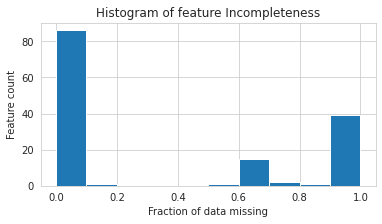

In [ ]:
plt.figure(figsize=(6,3))
missing_fractions.plot.hist(bins=10)
plt.title('Histogram of feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

In [ ]:
drop_list = sorted(list(missing_fractions[missing_fractions>0.5].index))
print(drop_list)
print(len(drop_list))

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_o

In [ ]:
loans.drop(labels=drop_list, axis=1, inplace=True)
loans.shape

(1303607, 87)

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, I would like to remove the features that were unavailable before lending a loan.

In [ ]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title','funded_amnt', 'funded_amnt_inv', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']
print(len(keep_list))
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)
print(len(drop_list))

33
['pymnt_plan', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'tota

In [ ]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [ ]:
loans.shape

(1303607, 30)

In [ ]:
print(loans.dtypes)
loans.select_dtypes('object').apply(pd.Series.nunique, axis=0)

loan_amnt                 int64
funded_amnt               int64
funded_amnt_inv         float64
term                     object
int_rate                float64
installment             float64
grade                    object
sub_grade                object
emp_title                object
emp_length               object
home_ownership           object
annual_inc              float64
verification_status      object
issue_d                  object
loan_status              object
purpose                  object
title                    object
zip_code                 object
addr_state               object
dti                     float64
earliest_cr_line         object
open_acc                float64
pub_rec                 float64
revol_bal                 int64
revol_util              float64
total_acc               float64
initial_list_status      object
application_type         object
mort_acc                float64
pub_rec_bankruptcies    float64
dtype: object


term                        2
grade                       7
sub_grade                  35
emp_title              371435
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   139
loan_status                 2
purpose                    14
title                   61678
zip_code                  943
addr_state                 51
earliest_cr_line          738
initial_list_status         2
application_type            2
dtype: int64

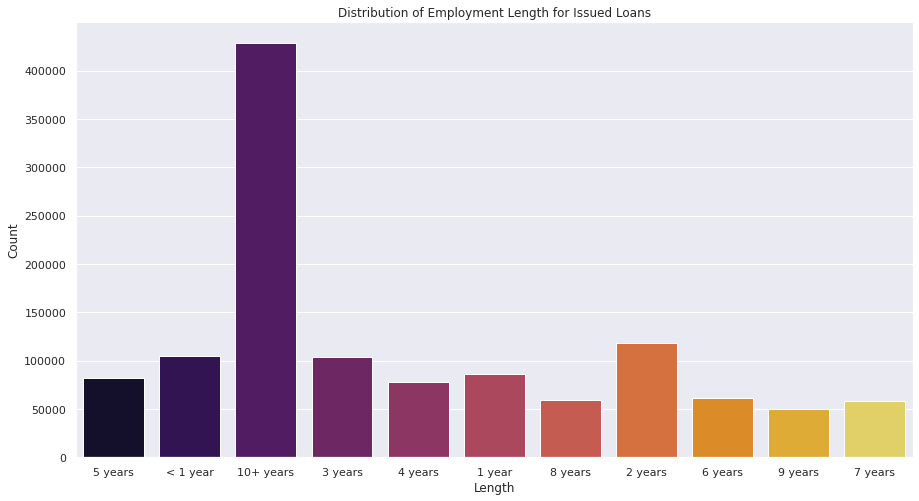

In [ ]:
sns.set(rc={'figure.figsize':(15,8)})
sns.countplot(loans['emp_length'], palette='inferno')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employment Length for Issued Loans")
plt.show()

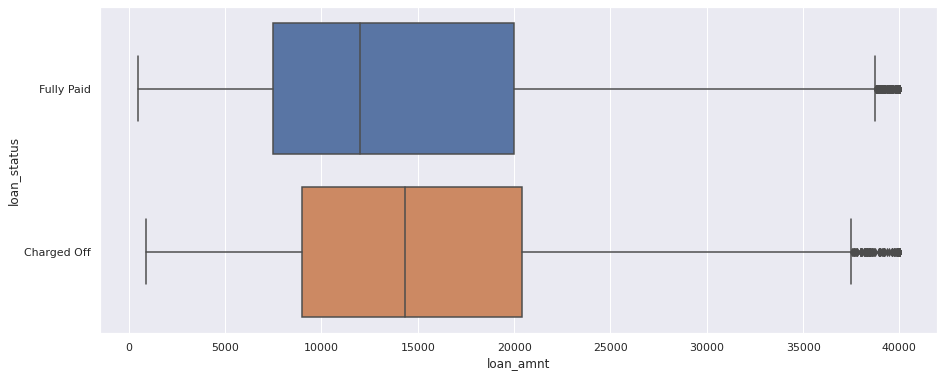

In [ ]:
sns.set(rc={'figure.figsize':(15,6)})
sns.boxplot(x="loan_amnt", y='loan_status', data=loans)

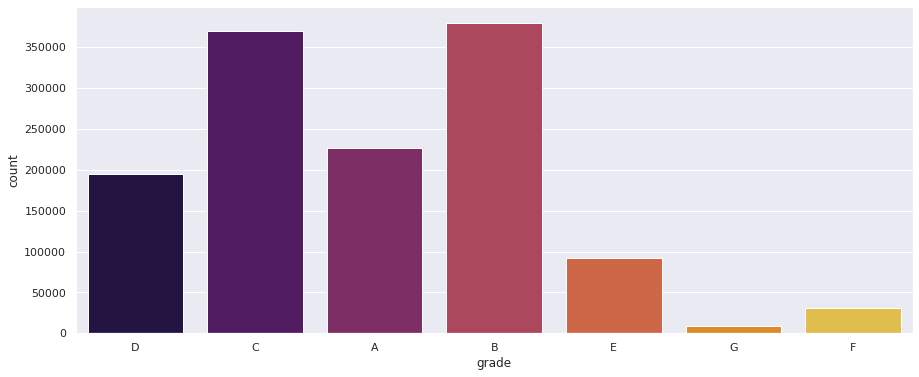

In [ ]:
sns.set(rc={'figure.figsize':(15,6)})
sns.countplot(loans['grade'], palette='inferno')

Text(0, 0.5, 'Average Loan Amount')

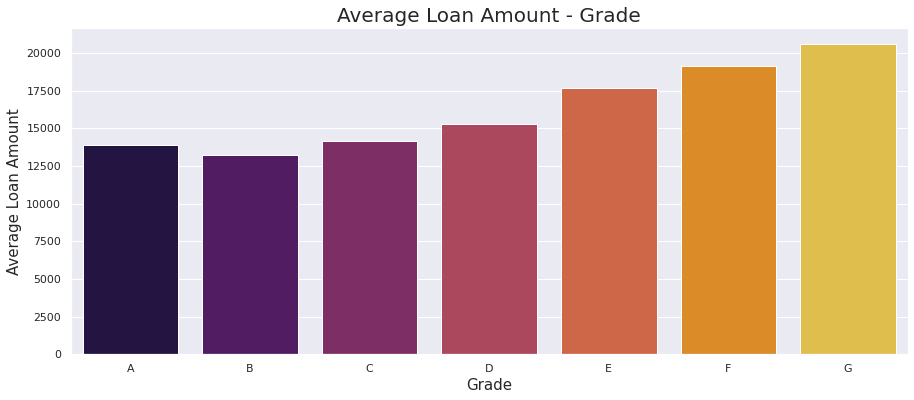

In [ ]:
loan_grades = loans.groupby("grade").mean().reset_index()

sns.set(rc={'figure.figsize':(15,6)})
sns.barplot(x='grade', y='loan_amnt', data=loan_grades, palette='inferno')
plt.title('Average Loan Amount - Grade', fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Average Loan Amount", fontsize=15)

**The average loan amount of B grade loans is least of all the grades. Also as the loan grades increase the amount also increases in the above figure**


Text(0, 0.5, 'Interest rate')

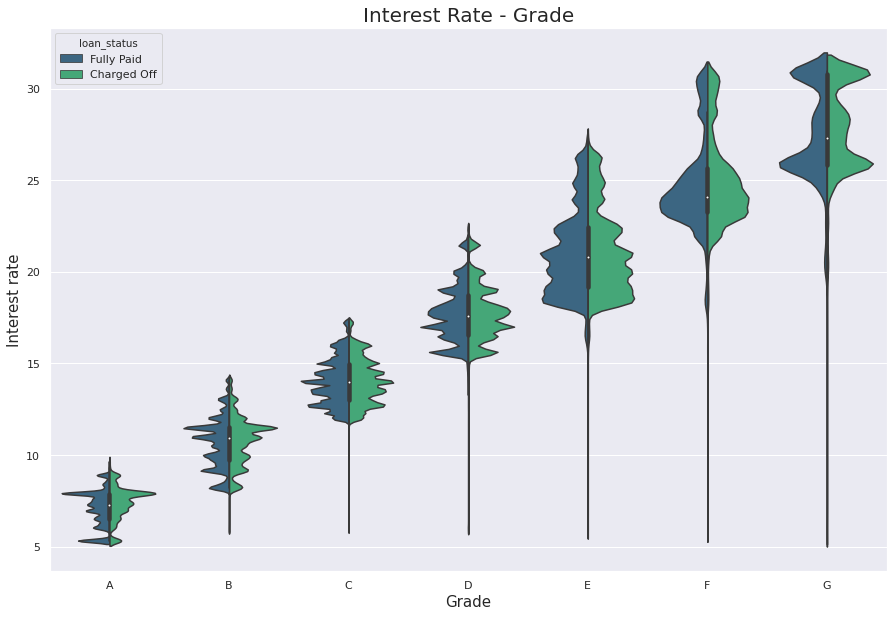

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x='grade', y='int_rate', data=loans, palette='viridis', order='ABCDEFG', hue='loan_status', split=True)
plt.title("Interest Rate - Grade", fontsize=20)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest rate", fontsize=15)

**The higher the loan amount, higher the interest rate.**

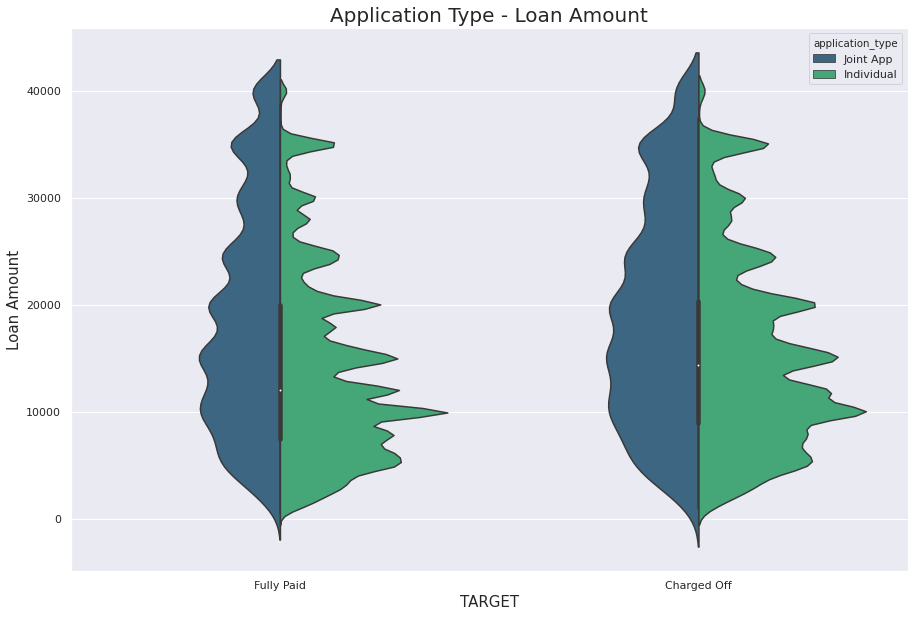

In [ ]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="loan_status",y="loan_amnt",data=loans, hue="application_type", split=True,palette='viridis')
plt.title("Application Type - Loan Amount", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

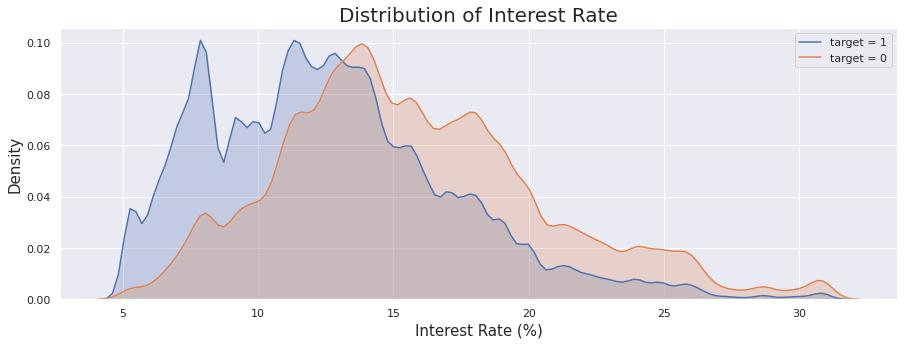

In [ ]:
sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(loans.loc[loans['loan_status'] == 'Fully Paid', 'int_rate'], label = 'target = 1',shade=True)
sns.kdeplot(loans.loc[loans['loan_status'] == 'Charged Off', 'int_rate'], label = 'target = 0',shade=True);
plt.xlabel('Interest Rate (%)',fontsize=15)
plt.ylabel('Density',fontsize=15)
plt.title('Distribution of Interest Rate',fontsize=20);

**Cases defaulted by states**

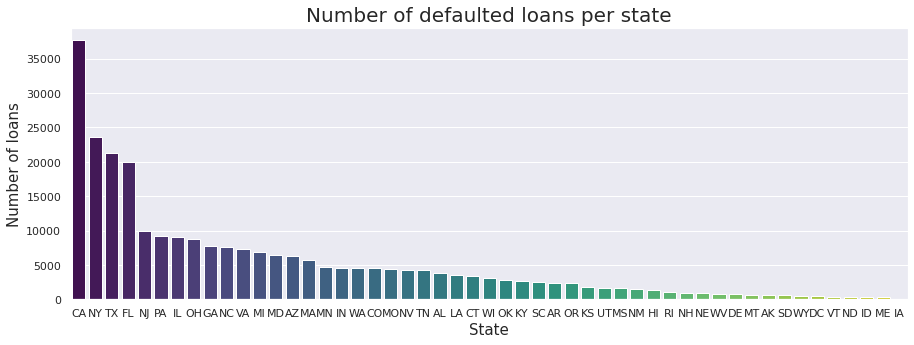

In [ ]:
state_default = loans[loans['loan_status']=='Charged Off']['addr_state']

sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(state_default, order=state_default.value_counts().index, palette='viridis')
plt.xlabel('State',fontsize=15)
plt.ylabel('Number of loans',fontsize=15)
plt.title('Number of defaulted loans per state',fontsize=20);

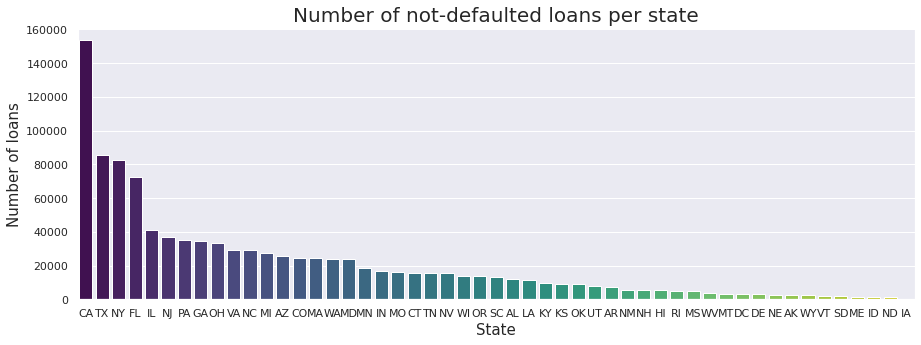

In [ ]:
state_non_default = loans[loans['loan_status']=='Fully Paid']['addr_state']

sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(state_non_default, order=state_non_default.value_counts().index, palette='viridis')
plt.xlabel('State',fontsize=15)
plt.ylabel('Number of loans',fontsize=15)
plt.title('Number of not-defaulted loans per state',fontsize=20);


**Converting the data type of issue date from object to int; onlt retaining the year columns**

In [ ]:
categorical = []
for column in loans:
    if loans[column].dtype == 'object':
        categorical.append(column)
categorical

['term',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'verification_status',
 'issue_d',
 'loan_status',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'earliest_cr_line',
 'initial_list_status',
 'application_type']

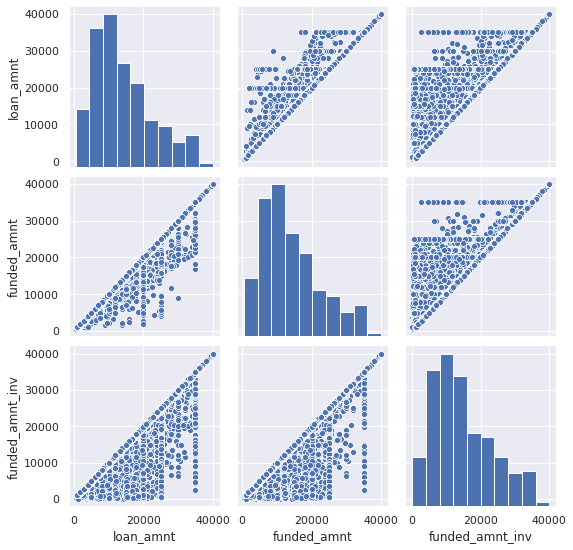

In [ ]:
sns.pairplot(vars=['loan_amnt','funded_amnt','funded_amnt_inv'], data=loans)

In [ ]:
loans['issue_d'] = pd.to_datetime(loans['issue_d']).apply(lambda x: int(x.strftime('%Y')))
print(loans['issue_d'].head())
print(loans['issue_d'].dtypes)

100    2018
152    2018
170    2018
186    2018
215    2018
Name: issue_d, dtype: int64
int64


In [ ]:
loans['emp_length'].head(20)

100      5 years
152     < 1 year
170    10+ years
186    10+ years
215      3 years
269      4 years
271    10+ years
296      5 years
369      5 years
379      4 years
402      3 years
412    10+ years
445    10+ years
510      5 years
576    10+ years
646    10+ years
765      4 years
800       1 year
829     < 1 year
835       1 year
Name: emp_length, dtype: object

In [ ]:
employment_length = ['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
                    '4 years', '5 years', '6 years', '2 years', '7 years', 'n/a']

lst = [loans]

loans['emp_length_int'] = np.nan

for col in lst:
    col.loc[col['emp_length'] == '10+ years', "emp_length_int"] = 10
    col.loc[col['emp_length'] == '9 years', "emp_length_int"]   = 9
    col.loc[col['emp_length'] == '8 years', "emp_length_int"]   = 8
    col.loc[col['emp_length'] == '7 years', "emp_length_int"]   = 7
    col.loc[col['emp_length'] == '6 years', "emp_length_int"]   = 6
    col.loc[col['emp_length'] == '5 years', "emp_length_int"]   = 5
    col.loc[col['emp_length'] == '4 years', "emp_length_int"]   = 4
    col.loc[col['emp_length'] == '3 years', "emp_length_int"]   = 3
    col.loc[col['emp_length'] == '2 years', "emp_length_int"]   = 2
    col.loc[col['emp_length'] == '1 years', "emp_length_int"]   = 1
    col.loc[col['emp_length'] == '< 1 year', "emp_length_int"]  = 0.5
    col.loc[col['emp_length'] == 'n/a', "emp_length_int"]       = 0

In [ ]:
loans['emp_length_int'].head()

100     5.0
152     0.5
170    10.0
186    10.0
215     3.0
Name: emp_length_int, dtype: float64

In [ ]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [ ]:
loans['term'].value_counts(normalize=True)

36    0.758476
60    0.241524
Name: term, dtype: float64

In [ ]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [ ]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    645496
RENT        517808
OWN         139844
OTHER          459
Name: home_ownership, dtype: int64

In [ ]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.172986
OTHER       0.187364
OWN         0.207453
RENT        0.233477
Name: loan_status, dtype: float64

In [ ]:
loans['annual_inc'].describe()

count    1.303607e+06
mean     7.615899e+04
std      7.004890e+04
min      0.000000e+00
25%      4.584000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

In [ ]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [ ]:
loans.drop('annual_inc', axis=1, inplace=True)

In [ ]:
loans['log_annual_inc'].describe()

count    1.303607e+06
mean     4.812791e+00
std      2.453588e-01
min      0.000000e+00
25%      4.661254e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: log_annual_inc, dtype: float64

In [ ]:
loans['purpose'].value_counts()

debt_consolidation    757591
credit_card           285704
home_improvement       84495
other                  74934
major_purchase         28328
medical                15023
small_business         15010
car                    14120
moving                  9172
vacation                8732
house                   6967
wedding                 2294
renewable_energy         911
educational              326
Name: purpose, dtype: int64

In [ ]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
wedding               0.121622
car                   0.146388
credit_card           0.170267
educational           0.171779
home_improvement      0.178531
major_purchase        0.187235
vacation              0.192396
other                 0.211706
debt_consolidation    0.212567
house                 0.217167
medical               0.219064
moving                0.234409
renewable_energy      0.237102
small_business        0.297468
Name: loan_status, dtype: float64

In [ ]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(s[-4:]))

In [ ]:
loans['earliest_cr_line'].describe()

count    1.303607e+06
mean     1.998651e+03
std      7.590199e+00
min      1.934000e+03
25%      1.995000e+03
50%      2.000000e+03
75%      2.004000e+03
max      2.015000e+03
Name: earliest_cr_line, dtype: float64

In [ ]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1)) 

In [ ]:
loans.drop('revol_bal', axis=1, inplace=True)

In [ ]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261655.0,3.987228,0.512545,0.0,3.778585,4.044853,4.281738,6.242223
Fully Paid,1041952.0,3.994177,0.534899,0.0,3.773786,4.047431,4.299115,6.463122


In [ ]:
loans['revol_util'].describe()

count    1.302797e+06
mean     5.191014e+01
std      2.450155e+01
min      0.000000e+00
25%      3.360000e+01
50%      5.230000e+01
75%      7.080000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

In [ ]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261487.0,54.896443,23.828058,0.0,37.6,55.7,73.2,366.6
Fully Paid,1041310.0,51.160233,24.610939,0.0,32.6,51.4,70.1,892.3


In [ ]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.199884
Joint App     0.246546
Name: loan_status, dtype: float64

In [ ]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [ ]:
filter_list = ['emp_title','title','zip_code','addr_state', 'emp_length',
               'grade','issue_d']
for name in filter_list:
    loans = loans.drop(name, axis=1)

In [ ]:
list_float = loans.select_dtypes(exclude=['object']).columns
print(list_float)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies',
       'emp_length_int', 'log_annual_inc', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [ ]:
def KS_test(feature):
    dist1 = loans.loc[loans.charged_off == 0, feature]
    dist2 = loans.loc[loans.charged_off == 1, feature]
    print(feature+':')
    print(ks_2samp(dist1, dist2),'\n')

In [ ]:
from statsmodels.stats.proportion import proportions_ztest
def Z_test(feature):
    dist1 = loans.loc[loans.charged_Off == 0, feature]
    dist2 = loans.loc[loans.charged_Off == 1, feature]
    n1 = len(dist1)
    p1 = dist1.sum()
    n2 = len(dist2)
    p2 = dist2.sum()
    z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
    print(feature+':')
    print('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')

In [ ]:
from scipy.stats import chi2_contingency
def run_chi2_test(df, feature):

    dist1 = df.loc[df.loan_status == 'Fully Paid',feature].value_counts().sort_index().tolist()
    dist2 = df.loc[df.loan_status == 'Charged Off',feature].value_counts().sort_index().tolist()
    chi2, p, dof, expctd = chi2_contingency([dist1,dist2])
    print(feature+':')
    print("chi-square test statistic:", chi2)
    print("p-value", p, '\n')

In [ ]:
for i in list_float:
    KS_test(i)

loan_amnt:
Ks_2sampResult(statistic=0.08289190324017615, pvalue=0.0) 

funded_amnt:
Ks_2sampResult(statistic=0.08297418289578479, pvalue=0.0) 

funded_amnt_inv:
Ks_2sampResult(statistic=0.08277105744447122, pvalue=0.0) 

term:
Ks_2sampResult(statistic=0.18796284632722182, pvalue=0.0) 

int_rate:
Ks_2sampResult(statistic=0.2661836737181286, pvalue=0.0) 

installment:
Ks_2sampResult(statistic=0.07090581986187877, pvalue=0.0) 

dti:
Ks_2sampResult(statistic=0.11533164175517313, pvalue=0.0) 

earliest_cr_line:
Ks_2sampResult(statistic=0.054836807502904206, pvalue=0.0) 

open_acc:
Ks_2sampResult(statistic=0.029875498158853764, pvalue=1.468285507206118e-162) 

pub_rec:
Ks_2sampResult(statistic=0.029528346822388696, pvalue=8.182702370471844e-159) 

revol_util:
Ks_2sampResult(statistic=0.06550719536472516, pvalue=0.0) 

total_acc:
Ks_2sampResult(statistic=0.017829042905703918, pvalue=3.613141796259668e-58) 

mort_acc:
Ks_2sampResult(statistic=0.09383964644807696, pvalue=0.0) 

pub_rec_bankrupt

In [ ]:
cor = loans[list_float].corr()
cor.loc[:,:] = np.tril(cor, k=-1) # below main lower triangle of an array
cor = cor.stack()
cor[(cor > 0.1) | (cor < -0.1)]

funded_amnt      loan_amnt               0.999546
funded_amnt_inv  loan_amnt               0.998515
                 funded_amnt             0.999063
term             loan_amnt               0.381541
                 funded_amnt             0.380719
                                           ...   
log_revol_bal    pub_rec_bankruptcies   -0.131319
                 emp_length_int          0.105964
                 log_annual_inc          0.298806
charged_off      term                    0.175899
                 int_rate                0.258412
Length: 83, dtype: float64

In [ ]:
dummy_list =['sub_grade','home_ownership','verification_status','purpose','initial_list_status','application_type']

In [ ]:
loans = pd.get_dummies(loans, columns=dummy_list, drop_first=True)
print(loans.shape)
print(loans.head())

(1303607, 72)
     loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
100      30000        30000          30000.0    36     22.35      1151.16   
152      40000        40000          40000.0    60     16.14       975.71   
170      20000        20000          20000.0    36      7.56       622.68   
186       4500         4500           4500.0    36     11.31       147.99   
215       8425         8425           8425.0    36     27.27       345.18   

       dti  earliest_cr_line  open_acc  pub_rec  revol_util  total_acc  \
100  30.46              2012      11.0      1.0        37.0       19.0   
152  50.53              2009      18.0      0.0        64.5       37.0   
170  18.92              1999       9.0      0.0        29.9       19.0   
186   4.64              2003      12.0      0.0        15.3       25.0   
215  12.37              1997      21.0      0.0        65.7       37.0   

     mort_acc  pub_rec_bankruptcies  emp_length_int  log_annual_inc  \
100    

In [ ]:
loans_train = loans.drop('charged_off', axis=1)
X_train, X_test, y_train, y_test = train_test_split(loans_train, loans['charged_off'], test_size=0.4, random_state=42)

In [ ]:
print(X_train.shape)

(782164, 71)


In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(X_train)

X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)


In [ ]:
X_train.isnull().mean()

loan_amnt                     0.0
funded_amnt                   0.0
funded_amnt_inv               0.0
term                          0.0
int_rate                      0.0
                             ... 
purpose_small_business        0.0
purpose_vacation              0.0
purpose_wedding               0.0
initial_list_status_w         0.0
application_type_Joint App    0.0
Length: 71, dtype: float64

In [ ]:
scalar = StandardScaler()

scalar.fit(X_train)

X_train = pd.DataFrame(scalar.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scalar.transform(X_test), columns=X_test.columns)

In [ ]:
y_test.isnull().any()

False

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(X_train.values)
# principalDf = pd.DataFrame(data = principalComponents, 
#                            columns=['principal component 1', 'principal component 2', 
#                                     'principal component 3', 'principal component 4',
#                                     'principal component 5', 'principal component 6',
#                                     'principal component 7', 'principal component 8',
#                                     'principal component 9', 'principal component 10',
#                                     'principal component 11', 'principal component 12',
#                                     'principal component 13', 'principal component 14',
#                                     'principal component 15', 'principal component 16',
#                                     'principal component 17', 'principal component 18',
#                                     'principal component 19', 'principal component 20'])

In [ ]:
pca.explained_variance_ratio_*100

array([7.22936382, 3.73392976, 2.73842997, 2.47838922, 2.30475097,
       2.11793109, 2.05560187, 1.98366023, 1.76332641, 1.51790524,
       1.49802231, 1.48853114, 1.48206665, 1.47444702, 1.47130408,
       1.46629419, 1.46478799, 1.4595553 , 1.45572281, 1.44781851,
       1.44376761, 1.43792213, 1.4337023 , 1.4321169 , 1.43089418])

In [ ]:
linear_corr = pd.DataFrame()

In [ ]:
for col in X_train.columns:
    linear_corr.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_corr['abs_pearson_corr'] = abs(linear_corr['pearson_corr'])
linear_corr.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_corr.drop('abs_pearson_corr', axis=1, inplace=True)
linear_corr.reset_index(inplace=True)

In [ ]:
linear_corr.head(10)

,index,pearson_corr
0,initial_list_status_w,-0.005133
1,purpose_wedding,0.005041
2,purpose_home_improvement,-0.004565
3,sub_grade_G5,-0.003551
4,sub_grade_E1,-0.003407
5,sub_grade_F5,-0.003393
6,purpose_renewable_energy,0.003271
7,purpose_small_business,0.003067
8,term,0.003007
9,sub_grade_G3,0.002958


In [ ]:
linear_corr.tail(10)

,index,pearson_corr
61,mort_acc,-0.000342
62,sub_grade_G4,0.000315
63,sub_grade_C3,-0.000286
64,emp_length_int,-0.000174
65,sub_grade_B4,0.000164
66,dti,0.000077
67,purpose_medical,-0.000077
68,sub_grade_B2,0.000024
69,sub_grade_D4,0.000017
70,sub_grade_C1,0.000002


In [ ]:
kfold = 3
random_state = 42 

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
pipeline_sgldr = Pipeline([('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=random_state, warm_start=True))])

In [ ]:
param_grid_sgdlr = {
    'model__alpha':[10**-5, 10**-1, 10**2],
    'model__penalty':['l1','l2']
}

In [ ]:
grid_sgdlr = GridSearchCV(estimator=pipeline_sgldr, param_grid=param_grid_sgdlr,
                          scoring='roc_auc',n_jobs=-1, pre_dispatch='2*n_jobs',
                          cv=kfold, verbose=1, return_train_score=False)

In [ ]:
grid_sgdlr.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   50.3s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('model',
                                        SGDClassifier(alpha=0.0001,
                                                      average=False,
                                                      class_weight=None,
                                                      early_stopping=False,
                                                      epsilon=0.1, eta0=0.0,
                                                      fit_intercept=True,
                                                      l1_ratio=0.15,
                                                      learning_rate='optimal',
                                                      loss='log', max_iter=1000,
                                                      n_iter_no_change=5,
                                                      n_jobs=None, penalty='l2',
                                                 

In [ ]:
sgdlr_estimator = grid_sgdlr.best_estimator_
print('Best Score:', grid_sgdlr.best_score_)
print('Best parameters set:\n', grid_sgdlr.best_params_)

Best Score: 0.7068133416904594
Best parameters set:
 {'model__alpha': 0.1, 'model__penalty': 'l2'}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFECV
from sklearn import decomposition

In [ ]:
pipeline_knn = Pipeline([('pca', decomposition.PCA()),
                         ('model', KNeighborsClassifier(n_jobs=-1))])

pipeline_knn2 = Pipeline([('lda', LinearDiscriminantAnalysis()),
                          ('model',KNeighborsClassifier(n_jobs=-1))])

param_grid_knn = {'pca__n_components':[8, 16, 24],
                  'model__n_neighbors':[5, 25, 125]}

param_grid_knn2 = {'lda__n_components':[3,9,12],
                   'model__n_neighbors':[5, 25, 125]}

In [ ]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn,
                        scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs',
                        cv=kfold, verbose=1, return_train_score=False)

grid_knn2 = GridSearchCV(estimator=pipeline_knn2, param_grid=param_grid_knn2,
                        scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs',
                        cv=kfold, verbose=1, return_train_score=False)

In [ ]:
grid_knn.fit(X_train, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
grid_knn2.fit(X_train, y_train) 

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  3.1min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('lda',
                                        LinearDiscriminantAnalysis(n_components=None,
                                                                   priors=None,
                                                                   shrinkage=None,
                                                                   solver='svd',
                                                                   store_covariance=False,
                                                                   tol=0.0001)),
                                       ('model',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
     

In [ ]:
knn_estimator = grid_knn.best_estimator_
print('Best Score:', grid_knn.best_score_)
print('Best parameters set:\n', grid_knn.best_params_)

AttributeError: ignored

In [ ]:
knn_estimator2 = grid_knn2.best_estimator_
print('Best Score:', grid_knn2.best_score_)
print('Best parameters set:\n', grid_knn2.best_params_)

Best Score: 0.7013072888370889
Best parameters set:
 {'lda__n_components': 3, 'model__n_neighbors': 125}


In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_pred = grid_knn2.best_estimator_.predict(X_test)
y_prob = grid_knn2.best_estimator_.predict_proba(X_test)[:,1]

In [ ]:
score = roc_auc_score(y_test, y_prob)

In [ ]:
matrix = metrics.confusion_matrix(y_test, y_pred)

In [ ]:
print("KNN score:", score)

KNN score: 0.6980807814128197


In [ ]:
print('KNN:\n{}\n'.format(metrics.classification_report(y_test,y_pred)))

KNN:
              precision    recall  f1-score   support

           0       0.81      0.98      0.89    416620
           1       0.51      0.06      0.11    104823

    accuracy                           0.80    521443
   macro avg       0.66      0.52      0.50    521443
weighted avg       0.75      0.80      0.73    521443




In [ ]:
print('KNN matrix:\n{}\n'.format(matrix))

KNN matrix:
[[410178   6442]
 [ 98046   6777]]



In [ ]:
y_pred = grid_sgdlr.best_estimator_.predict(X_test)
y_prob = grid_sgdlr.best_estimator_.predict_proba(X_test)[:,1]

In [ ]:
score = roc_auc_score(y_test, y_prob)

In [ ]:
matrix = metrics.confusion_matrix(y_test, y_pred)

In [ ]:
print('Logistic Regression roc_auc_score:',score)

Logistic Regression roc_auc_score: 0.7037102959087996


In [ ]:
print('Logistic Regression')

In [ ]:
loans['revol_util'].fillna(loans['revol_util'].mean() , inplace=True)

In [ ]:
loans['dti'].fillna(loans['dti'].mean(), inplace=True)

In [ ]:
loans['mort_acc'].fillna(loans['mort_acc'].mode()[0], inplace=True)

In [ ]:
loans['pub_rec_bankruptcies'].fillna(loans['pub_rec_bankruptcies'].mode()[0], inplace=True)

In [ ]:
loans.isnull().sum()

loan_amnt                    0
funded_amnt                  0
funded_amnt_inv              0
term                         0
int_rate                     0
installment                  0
grade                        0
sub_grade                    0
home_ownership               0
annual_inc                   0
verification_status          0
issue_d                      0
loan_status                  0
purpose                      0
dti                          0
earliest_cr_line             0
open_acc                     0
pub_rec                      0
revol_bal                    0
revol_util                   0
total_acc                    0
initial_list_status          0
application_type             0
mort_acc                     0
pub_rec_bankruptcies         0
emp_length_int          161131
dtype: int64

In [ ]:
loans.drop('emp_length_int', axis=1, inplace=True)

In [ ]:
mapping_dict = {"grade":{"A":1, "B":2, "C":3, "D":4, "E":5, 
                         "F":6, "G":7}}
loans = loans.replace(mapping_dict)
loans[['grade']].head()

,grade
100,4
152,3
170,1
186,2
215,5


In [ ]:
nominal_columns = ["home_ownership","verification_status",
                   "purpose", "term"]
dummy_df = pd.get_dummies(loans[nominal_columns])
loans = pd.concat([loans, dummy_df], axis=1)
loans = loans.drop(nominal_columns, axis=1)

In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1303607 entries, 100 to 2260664
Data columns (total 46 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   loan_amnt                            1303607 non-null  int64  
 1   funded_amnt                          1303607 non-null  int64  
 2   funded_amnt_inv                      1303607 non-null  float64
 3   int_rate                             1303607 non-null  float64
 4   installment                          1303607 non-null  float64
 5   grade                                1303607 non-null  int64  
 6   sub_grade                            1303607 non-null  object 
 7   annual_inc                           1303607 non-null  float64
 8   issue_d                              1303607 non-null  int64  
 9   loan_status                          1303607 non-null  object 
 10  dti                                  1303607 non-null  float64
 

In [ ]:
map_dict = {"sub_grade":{"A1":11, "A2":12, "A3":13, "A4":14, "A5":15,
            "B1":21, "B2":22, "B3":23, "B4":24, "B5":25,
            "C1":31, "C2":32, "C3":33, "C4":34, "C5":35,
            "D1":41, "D2":42, "D3":43, "D4":44, "D5":45,
            "E1":51, "E2":52, "E3":53, "E4":54, "E5":55,
            "F1":61, "F2":62, "F3":63, "F4":64, "F5":65,
            "G1":71, "G2":72, "G3":73, "G4":74, "G5":75    
            }}
loans = loans.replace(map_dict)
loans[['grade']].head()

,grade
100,4
152,3
170,1
186,2
215,5


In [ ]:
loans[['sub_grade']].head()

,sub_grade
100,45
152,34
170,13
186,23
215,55


In [ ]:
loan_status_dictionary = {"loan_status":{"Fully Paid": 0, 
                                         "Charged Off": 1}}
loans = loans.replace(loan_status_dictionary)
loans['loan_status'].head()

100    0
152    0
170    0
186    0
215    0
Name: loan_status, dtype: int64

In [ ]:
print(loans.dtypes)

loan_amnt                                int64
funded_amnt                              int64
funded_amnt_inv                        float64
int_rate                               float64
installment                            float64
grade                                    int64
sub_grade                                int64
annual_inc                             float64
issue_d                                  int64
loan_status                              int64
dti                                    float64
earliest_cr_line                        object
open_acc                               float64
pub_rec                                float64
revol_bal                                int64
revol_util                             float64
total_acc                              float64
initial_list_status                     object
application_type                        object
mort_acc                               float64
pub_rec_bankruptcies                   float64
home_ownershi

In [ ]:
nominal_column = ["initial_list_status","application_type"]
dummy_df = pd.get_dummies(loans[nominal_column])
loans = pd.concat([loans, dummy_df], axis=1)
loans = loans.drop(nominal_column, axis=1)

In [ ]:
print(loans.nunique(),'\n')
print(loans.head())

loan_amnt                               1553
funded_amnt                             1553
funded_amnt_inv                         9014
int_rate                                 654
installment                            82574
grade                                      7
sub_grade                                 35
annual_inc                             62988
issue_d                                   12
loan_status                                2
dti                                     6871
earliest_cr_line                          72
open_acc                                  84
pub_rec                                   37
revol_bal                              82819
revol_util                              1364
total_acc                                142
mort_acc                                  38
pub_rec_bankruptcies                      12
home_ownership_ANY                         2
home_ownership_MORTGAGE                    2
home_ownership_NONE                        2
home_owner

In [ ]:
loans['earliest_cr_line'] = pd.to_datetime(loans['earliest_cr_line']).apply(lambda x: int(x.strftime('%Y')))
print(loans['earliest_cr_line'].head())
print(loans['earliest_cr_line'].dtypes)

100    2012
152    2009
170    1999
186    2003
215    1997
Name: earliest_cr_line, dtype: int64
int64


In [ ]:
loans.reset_index(inplace = True)

In [ ]:
loans.drop('index', inplace=True, axis=1)
loans.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
0,30000,30000,30000.0,22.35,1151.16,4,45,100000.0,2018,0,30.46,2012,11.0,1.0,15603,37.0,19.0,1.0,1.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
1,40000,40000,40000.0,16.14,975.71,3,34,45000.0,2018,0,50.53,2009,18.0,0.0,34971,64.5,37.0,1.0,0.0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1
2,20000,20000,20000.0,7.56,622.68,1,13,100000.0,2018,0,18.92,1999,9.0,0.0,25416,29.9,19.0,5.0,0.0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
3,4500,4500,4500.0,11.31,147.99,2,23,38500.0,2018,0,4.64,2003,12.0,0.0,4472,15.3,25.0,0.0,0.0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0
4,8425,8425,8425.0,27.27,345.18,5,55,450000.0,2018,0,12.37,1997,21.0,0.0,36812,65.7,37.0,4.0,0.0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1


loan_amnt                              0
funded_amnt                            0
funded_amnt_inv                        0
int_rate                               0
installment                            0
grade                                  0
sub_grade                              0
annual_inc                             0
issue_d                                0
loan_status                            0
dti                                    0
earliest_cr_line                       0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc                              0
mort_acc                               0
pub_rec_bankruptcies                   0
home_ownership_ANY                     0
home_ownership_MORTGAGE                0
home_ownership_NONE                    0
home_ownership_OTHER                   0
home_ownership_OWN                     0
home_ownership_R

In [ ]:
loans.to_csv('/content/drive/My Drive/DA Assignment/lending-club-loan-data/loan_processed.csv', index=False, encoding='utf-8')

In [ ]:
loans.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,annual_inc,issue_d,loan_status,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
count,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06,1.303607e+06
mean,1.441681e+04,1.440812e+04,1.438520e+04,1.325722e+01,4.380850e+02,2.751486e+00,3.047963e+01,7.615899e+04,2.014921e+03,2.007162e-01,1.825875e+01,1.998651e+03,1.159234e+01,2.155220e-01,1.623599e+04,5.191014e+01,2.501894e+01,1.616056e+00,1.346265e-01,2.048163e-04,4.951615e-01,3.682091e-05,1.104627e-04,1.072747e-01,3.972117e-01,3.008614e-01,3.864094e-01,3.127292e-01,1.083149e-02,2.191642e-01,5.811498e-01,2.500754e-04,6.481631e-02,5.344402e-03,2.173048e-02,1.152418e-02,7.035863e-03,5.748205e-02,6.988302e-04,1.151421e-02,6.698338e-03,1.759733e-03,7.584755e-01,2.415245e-01,4.237420e-01,5.762580e-01,9.821748e-01,1.782516e-02
std,8.699542e+03,8.695472e+03,8.697984e+03,4.760544e+00,2.610632e+02,1.296941e+00,1.286217e+01,7.004890e+04,1.630593e+00,4.005363e-01,1.093718e+01,7.590199e+00,5.465282e+00,6.028619e-01,2.228629e+04,2.449394e+01,1.199584e+01,1.993169e+00,3.781873e-01,1.430995e-02,4.999768e-01,6.067914e-03,1.050955e-02,3.094622e-01,4.893207e-01,4.586327e-01,4.869264e-01,4.636052e-01,1.035093e-01,4.136803e-01,4.933709e-01,1.581180e-02,2.462016e-01,7.290983e-02,1.458022e-01,1.067304e-01,8.358448e-02,2.327615e-01,2.642617e-02,1.066848e-01,8.156884e-02,4.191226e-02,4.280076e-01,4.280076e-01,4.941507e-01,4.941507e-01,1.323157e-01,1.323157e-01
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,1.000000e+00,1.100000e+01,0.000000e+00,2.007000e+03,0.000000e+00,-1.000000e+00,1.934000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,8.000000e+03,7.900000e+03,9.750000e+00,2.488200e+02,2.000000e+00,2.200000e+01,4.584000e+04,2.014000e+03,0.000000e+00,1.179000e+01,1.995000e+03,8.000000e+00,0.000000e+00,5.952000e+03,3.360000e+01,1.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,1.200000e+04,1.200000e+04,1

In [ ]:
def plot_var(col_name, full_name, continuous):
    fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, figsize=(15,3))

    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loans[col_name], order=sorted(loans[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,1]
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(loans, hue = 'loan_status', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=loans, order=sorted(loans[col_name].unique()) )
     
    plt.tight_layout()

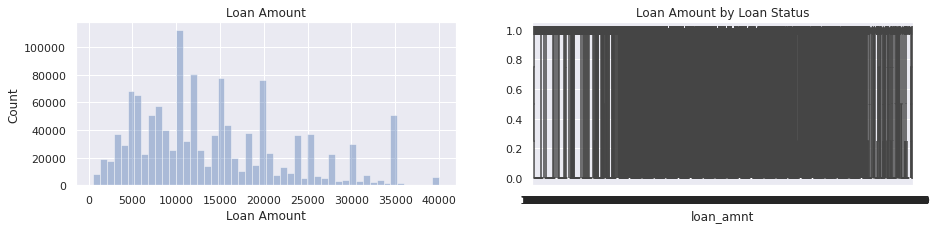

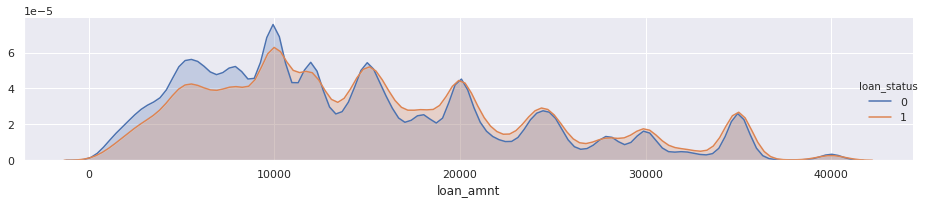

In [ ]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

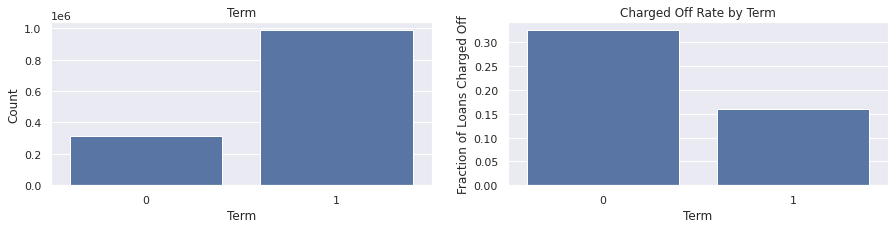

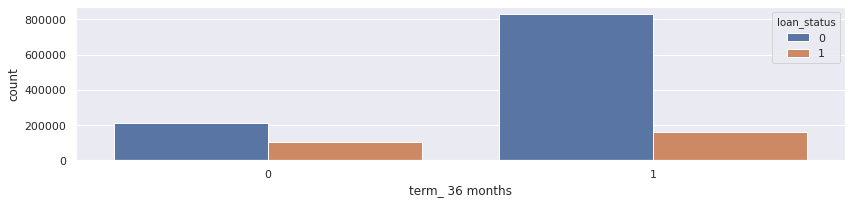

In [ ]:
plot_var('term_ 36 months', 'Term', continuous=False)

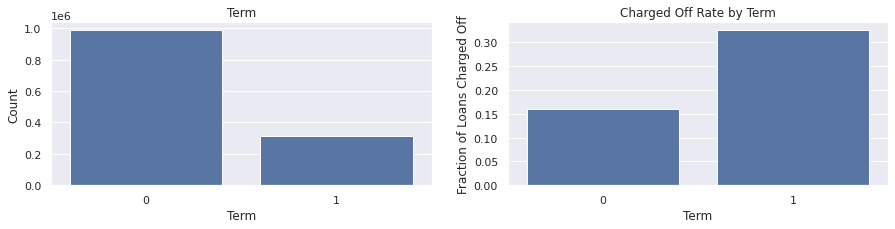

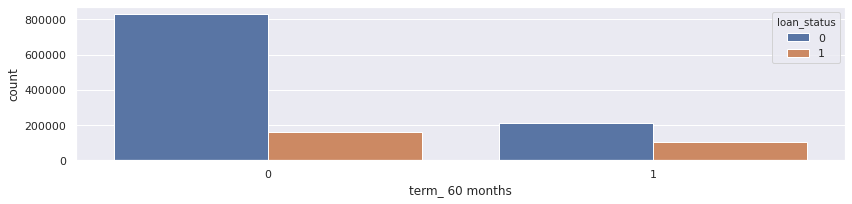

In [ ]:
plot_var('term_ 60 months', 'Term', continuous=False)

In [ ]:
loans.head()

NameError: ignored